In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

# 1.) Import, split data into X/y, plot y data as bar charts, turn X categorical variables binary and tts.

In [2]:
df = pd.read_csv("HR_Analytics.csv")

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
y = df[["Attrition"]].copy()
X = df.drop("Attrition", axis = 1)

In [6]:
y["Attrition"] = [1 if i == "Yes" else 0 for i in y["Attrition"]]

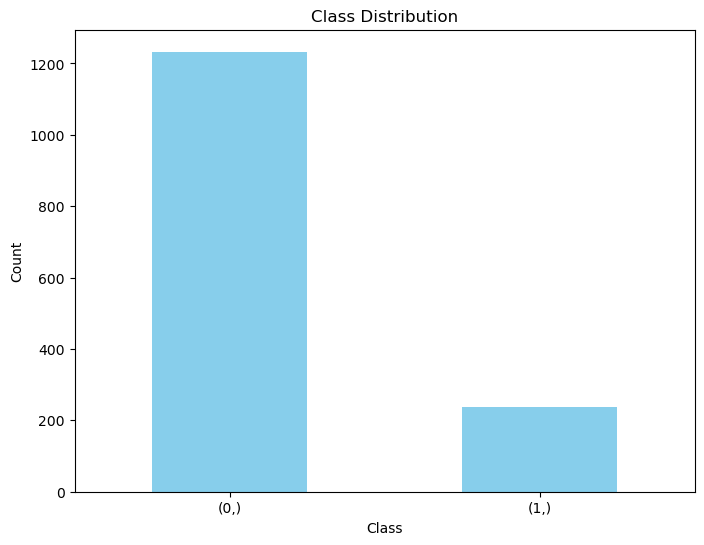

In [7]:
class_counts = y.value_counts()


plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Remove rotation of x-axis labels
plt.show()



In [8]:
# Step 1: Identify string columns
string_columns = X.columns[X.dtypes == 'object']

# Step 2: Convert string columns to categorical
for col in string_columns:
    X[col] = pd.Categorical(X[col])

# Step 3: Create dummy columns
X = pd.get_dummies(X, columns=string_columns, prefix=string_columns,drop_first=True)

# drop_first = True is important to avoid multicollinearity


In [9]:
x_train,x_test,y_train,y_test=train_test_split(X,
 y, test_size=0.20, random_state=42)


# 2.) Using the default Decision Tree. What is the IN/Out of Sample accuracy?

In [10]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  1.0
OUT OF SAMPLE ACCURACY :  0.79


In [11]:
#There is some overfitting here so we can reduce the in-sample accuracy by reducing the model complexity

# 3.) Run a grid search cross validation using F1 score to find the best metrics. What is the In and Out of Sample now?

In [12]:

# Define the hyperparameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),  # Range of max_depth values to try
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


dt_classifier = DecisionTreeClassifier(random_state=42)

scoring = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring, cv=5)

grid_search.fit(x_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)


Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1-Score: 0.8214764475510983


In [13]:
# we can take the above dictionary as parameters for the model below

In [14]:
clf = tree.DecisionTreeClassifier(**best_params, random_state =42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("IN SAMPLE ACCURACY : " , round(acc,2))

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OUT OF SAMPLE ACCURACY : " , round(acc,2))

IN SAMPLE ACCURACY :  0.91
OUT OF SAMPLE ACCURACY :  0.83


# 4.) Plot ......

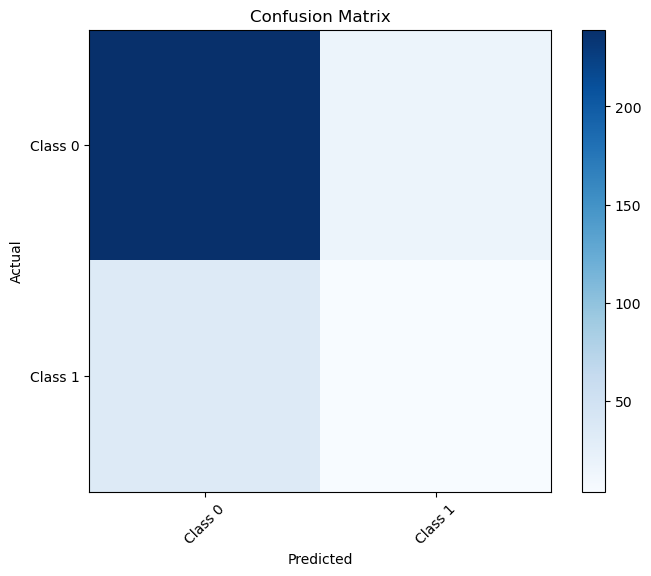

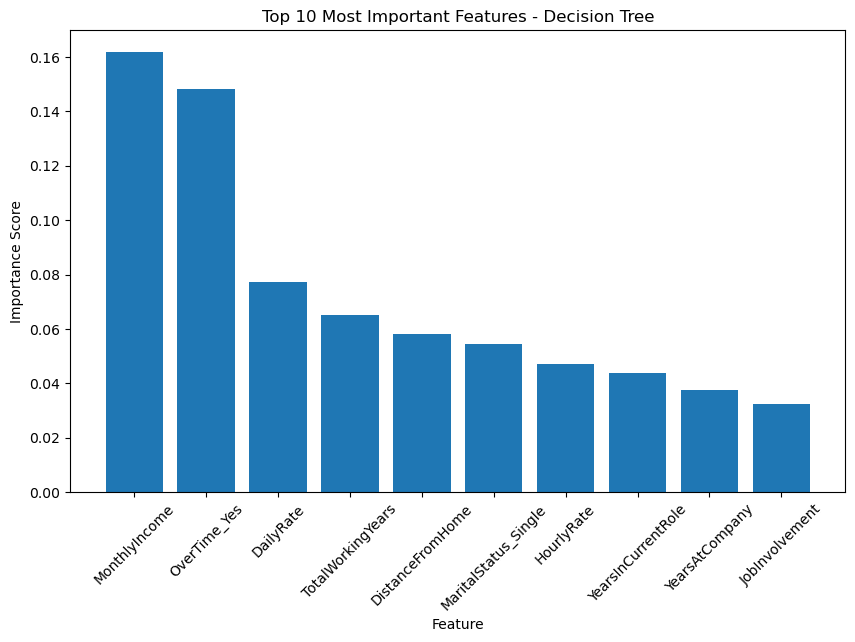

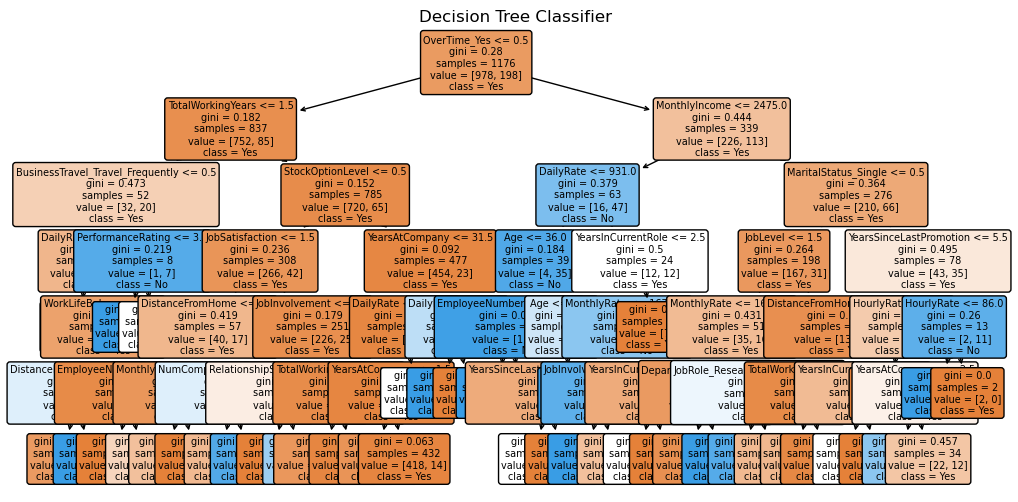

In [15]:
# Make predictions on the test data
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




feature_importance = clf.feature_importances_ 

# Sort features by importance and select the top 10
top_n = 10
top_feature_indices = np.argsort(feature_importance)[::-1][:top_n]
top_feature_names = X.columns[top_feature_indices]
top_feature_importance = feature_importance[top_feature_indices]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.xticks(rotation=45)
plt.show()

# Plot the Decision Tree for better visualization of the selected features
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Yes", "No"], rounded=True, fontsize=7)
plt.title('Decision Tree Classifier')
plt.show()



# 5.) Looking at the graphs. what would be your suggestions to try to improve employee retention? What additional information would you need for a better plan. Plot anything you think would assist in your assessment.

## ANSWER :
Increase hourly rate.

In [16]:
np.corrcoef(np.array(X['OverTime_Yes']), np.array(y['Attrition']))

array([[1.        , 0.24611799],
       [0.24611799, 1.        ]])

# 6.) Using the Training Data, if they made everyone stop overtime. What would have been the expected difference in employee retention?

In [17]:
x_train_experiment = x_train.copy()

x_train_experiment["OverTime_Yes"] = 0.

y_pred_experiment = clf.predict(x_train_experiment)
y_pred = clf.predict(x_train)

y_pred - y_pred_experiment

retention = sum(y_pred - y_pred_experiment)

In [18]:
print(f"Stopping overtime work would have prevented {retention} people from leaving")

Stopping overtime work would have prevented 59 people from leaving


# 7.) If they company loses an employee, there is a cost to train a new employee for a role ~2.8 * their monthly income.
# To make someone not work overtime costs the company 2K per person.
# Is it profitable for the company to remove overtime? If so/not by how much? 
# What do you suggest to maximize company profits?

In [19]:
x_train_experiment["Y"]= y_pred
x_train_experiment["Y_exp"] = y_pred_experiment
x_train_experiment["Ret_Change"] = x_train_experiment["Y"] - x_train_experiment["Y_exp"]

In [20]:
#x_train_experiment["Y_exp"] = y_pred_experiment
#x_train_experiment["Ret_Change"] = x_train_experiment["Y"] - x_train_experiment["Y_exp"]

In [21]:
# Saving: Change in training cost
sav = sum(x_train_experiment["Ret_Change"]* 2.8 * x_train_experiment["MonthlyIncome"])

In [22]:
# Cost of lost OverTime
cost = 2000 * len(x_train[x_train['OverTime_Yes'] == 1])

In [23]:
print("Profit from this experiment:", sav - cost)

Profit from this experiment: -117593.99999999977


In [24]:
# To maximize the company's profit

## ANSWER : 
based on results, keep overtime 

# 8.) Use your model and get the expected change in retention for raising and lowering peoples income. Plot the outcome of the experiment. Comment on the outcome of the experiment and your suggestions to maximize profit.

In [25]:
raise_amount = 500

In [35]:
profits = []
for raise_amount in range(-1000, 1000, 100):
    x_train_experiment = x_train.copy()
    x_train_experiment['MonthlyIncome'] = x_train_experiment['MonthlyIncome'] + raise_amount
    y_pred_experiment = clf.predict(x_train_experiment)
    y_pred = clf.predict(x_train)
    x_train_experiment["Y"] = y_pred
    x_train_experiment["Y_exp"] = y_pred_experiment
    x_train_experiment["Ret_Change"] = x_train_experiment["Y"] - x_train_experiment["Y_exp"]

    # Saving: Change in Training cost
    print("Retention difference", sum(x_train_experiment["Ret_Change"]))
    sav = sum(x_train_experiment["Ret_Change"]* 2.8 * x_train_experiment["MonthlyIncome"])

    # Cost of lost Overtime
    cost = raise_amount * len(x_train)


    print("Profit is ", sav - cost)
    profits.append(sav - cost)

Retention difference -16
Profit is  1087584.4
Retention difference -14
Profit is  979524.0
Retention difference -13
Profit is  864992.8
Retention difference -12
Profit is  750738.8
Retention difference -12
Profit is  629778.8
Retention difference -9
Profit is  530138.0
Retention difference -7
Profit is  424200.0
Retention difference -4
Profit is  326096.4
Retention difference -1
Profit is  228440.8
Retention difference -1
Profit is  110714.8
Retention difference 0
Profit is  0.0
Retention difference 6
Profit is  -75328.40000000001
Retention difference 15
Profit is  -127503.60000000002
Retention difference 15
Profit is  -240914.8
Retention difference 21
Profit is  -311586.80000000005
Retention difference 22
Profit is  -416449.6000000001
Retention difference 22
Profit is  -527889.6000000001
Retention difference 22
Profit is  -639329.6000000001
Retention difference 22
Profit is  -750769.6000000001
Retention difference 23
Profit is  -854999.6000000001


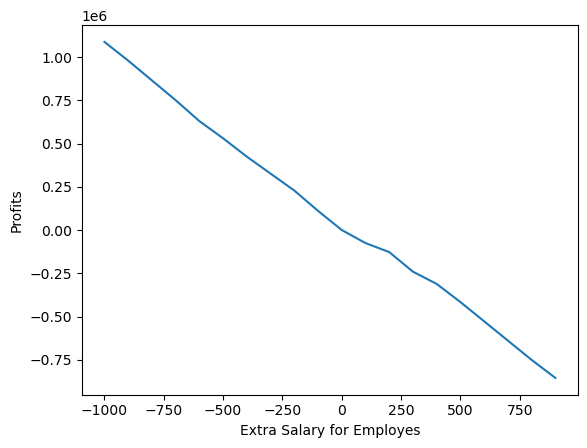

In [37]:
plt.plot(range(-1000, 1000, 100), profits)
plt.xlabel("Extra Salary for Employes")
plt.ylabel("Profits")
plt.show()

## ANSWER :  
The model suggests reducing everyone's compensation to boost profitability, however that would result in a high turnover rate.